# Opracowanie modelu regresji do przewidzenia liczby pasażerów transportu kolejowego
#### Autorzy: Szymon Kowalski, Zuzanna Czyżowska - zespół 18
## 1. Wprowadzenie

W poprzedniej części projektu, przeprowadziliśmy analizę naszego zbioru i na jej podstawie dokonaliśmy doboru cech do naszego modelu. Cechy zapisaliśmy do nowego pliku .csv, aby łatwo przejść do opracowania modelu regresji.

## 2. Importy i załadowanie danych

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [122]:
tables = pd.read_csv('all_data_after_analyze.csv')

print("Dane:")
print(tables.head())
print("Rozmiar danych:")
print(tables.shape)

Dane:
    n        year  country     pa_tr  pa_tr_na  pa_tr_in     tr_tr  \
0  18  2013-01-01  Austria  235434.0  225063.0   10371.0  134386.0   
1  11  2013-01-01  Croatia   24216.0   23810.0     406.0   16651.0   
2   3  2013-01-01  Czechia  174189.0  170790.0    3399.0  127109.0   
3   4  2013-01-01  Denmark  193500.0  181151.0   12349.0   67045.0   
4   6  2013-01-01  Estonia    4199.0    4077.0     122.0    3337.0   

       le_ra_tr  le_li_hi  le_li_up_hi  ...  n_lo_di  n_ra_di  n_lo_el  ca_ve  \
0   9708.000000       0.0        237.0  ...    464.0    226.0    888.0  269.0   
1   4090.000000       0.0          0.0  ...    159.0    106.0    107.0   33.0   
2  15607.000000       0.0          0.0  ...   1126.0    737.0    770.0  288.0   
3   3613.330147       0.0          0.0  ...     89.0   1088.0     36.0  141.0   
4   2146.000000       0.0          0.0  ...    293.0     46.0      0.0   24.1   

     ex_in    in_in          po  co_pr_le   le_mo    n_pa_air  
0  319.000  211.000   

## 3. Dobór cech i przygotowanie zbiorów

### 1. Cechy o najwyższej korelacji z cechą określaną

Cechy o najwyższej korelacji z 'pa_tr':
pa_tr          1.000000
ex_in          0.937190
le_ra_tr       0.867369
ca_ve          0.849487
n_co_tr        0.847892
in_in          0.845658
n_ra_di        0.816365
tr_tr          0.764917
n_pa_air       0.764773
po             0.750645
le_mo          0.697490
n_lo_el        0.661338
n_lo_di        0.653437
le_li_hi       0.435849
le_li_up_hi    0.351197
co_pr_le       0.254780
Name: pa_tr, dtype: float64


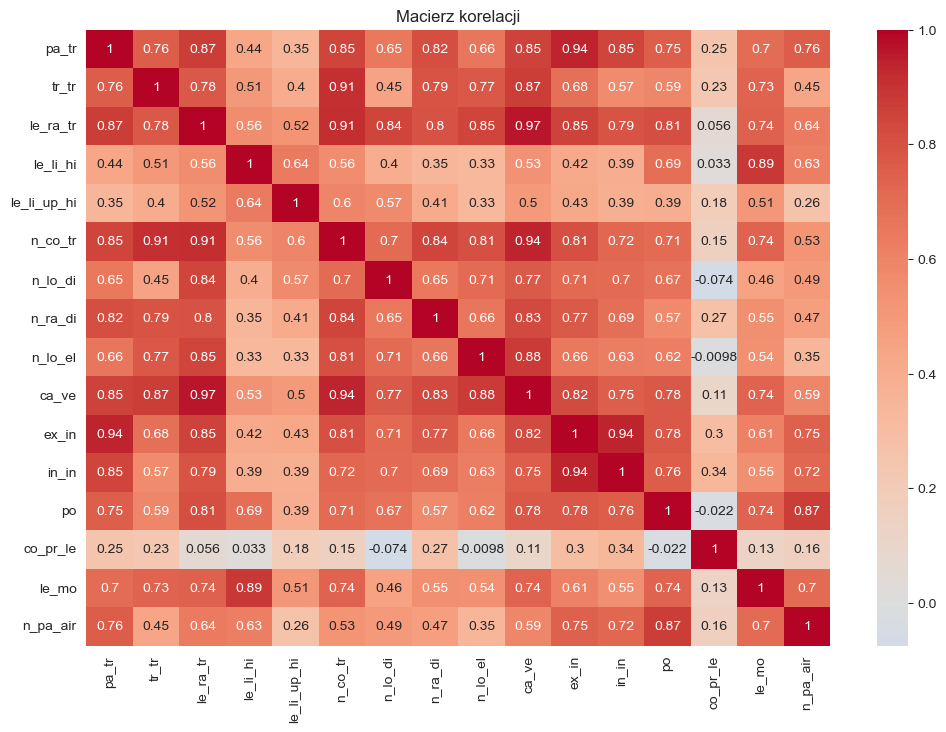

In [123]:
tables_drop_col = tables.drop(columns=['n', 'country', 'year','pa_tr_na', 'pa_tr_in'])
correlation_matrix = tables_drop_col.corr()

# Korelacja z celem (pa_tr)
target_correlation = correlation_matrix['pa_tr'].sort_values(ascending=False)

# Wyświetlenie cech o najwyższej korelacji
print("Cechy o najwyższej korelacji z 'pa_tr':")
print(target_correlation)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Macierz korelacji")
plt.show()

### 2. Podzielenie zbioru na uczący i testowy

In [124]:
X = tables_drop_col.drop(['pa_tr'], axis=1)
y = tables_drop_col['pa_tr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Rozmiar zbioru treningowego:", X_train.shape, "\nRozmiar zbioru testowego:", X_test.shape)

Rozmiar zbioru treningowego: (228, 15) 
Rozmiar zbioru testowego: (58, 15)


### 3. Metoda drzew losowych

Ważność cech według Random Forest:
        Feature  Importance
9         ex_in    0.758599
13        le_mo    0.099252
6       n_ra_di    0.042247
10        in_in    0.028361
8         ca_ve    0.015749
0         tr_tr    0.009518
1      le_ra_tr    0.007923
12     co_pr_le    0.007386
11           po    0.007320
4       n_co_tr    0.006718
3   le_li_up_hi    0.004366
5       n_lo_di    0.003950
2      le_li_hi    0.003406
14     n_pa_air    0.003322
7       n_lo_el    0.001882


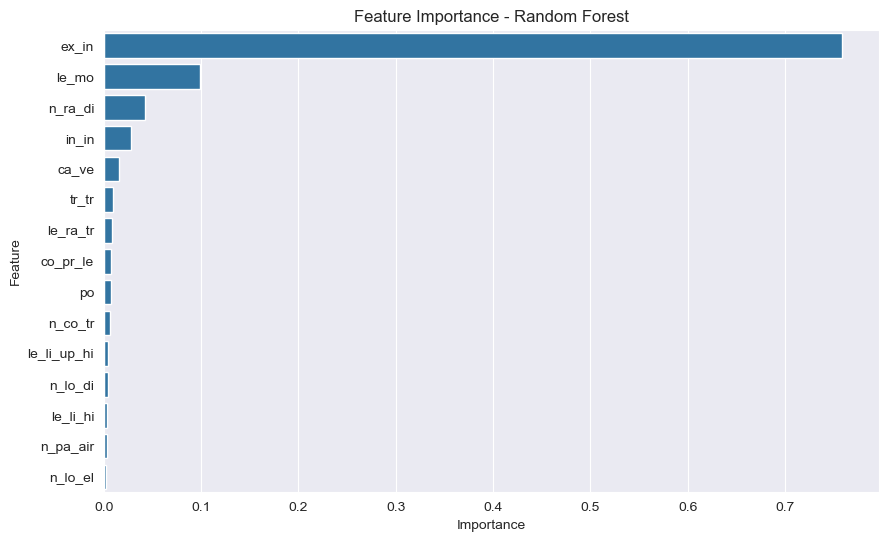

In [125]:
from sklearn.ensemble import RandomForestRegressor

# Model Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Ważność cech
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Ważność cech według Random Forest:")
print(feature_importances)

# Wizualizacja
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance - Random Forest")
plt.show()

### 4. Metoda Lasso

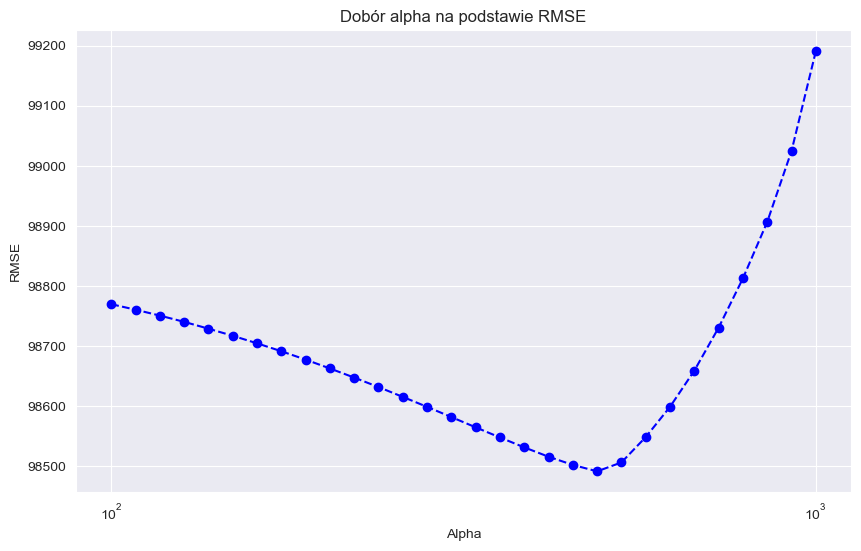

Najlepsze alpha na podstawie RMSE: 489.3900918477494


In [126]:
# Skalowanie cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista wartości alpha (logarytmicznie rozłożone)
alphas = np.logspace(2, 3, 30)

results = []

for alpha in alphas:

    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Alpha': alpha, 'RMSE': rmse})

results_df = pd.DataFrame(results)

# Wizualizacja wyników
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['Alpha'], results_df['RMSE'], marker='o', linestyle='--', color='b')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Dobór alpha na podstawie RMSE')
plt.xscale('log')
plt.show()

# Wybranie najlepszej wartości alpha (najmniejszy RMSE)
best_alpha = results_df.loc[results_df['RMSE'].idxmin(), 'Alpha']
print("Najlepsze alpha na podstawie RMSE:", best_alpha)

In [127]:
# Finalny model z najlepszym alpha
final_lasso = Lasso(alpha=best_alpha, random_state=42)
final_lasso.fit(X_train_scaled, y_train)

import numpy as np

# Wyświetlenie współczynników cech posortowanych po wartości bezwzględnej
print("Współczynniki cech dla najlepszego modelu LASSO (posortowane według wartości bezwzględnej):")
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': final_lasso.coef_,
    'Absolute Coefficient': np.abs(final_lasso.coef_)
}).sort_values(by='Absolute Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']])

Współczynniki cech dla najlepszego modelu LASSO (posortowane według wartości bezwzględnej):
        Feature    Coefficient
14     n_pa_air  252107.383033
9         ex_in  232962.664135
2      le_li_hi -229834.914080
4       n_co_tr  217435.462649
13        le_mo  195596.837303
1      le_ra_tr  147306.860077
11           po -133587.629157
8         ca_ve  -99435.582316
6       n_ra_di   52788.438284
10        in_in  -41971.324301
7       n_lo_el  -37918.783725
3   le_li_up_hi  -20062.120334
12     co_pr_le  -15055.352615
0         tr_tr    7430.806574
5       n_lo_di     349.091640


### 4. Utworzenie zbiorów danych na podstawie ważności cech

In [128]:
# Z korelacji
high_correlation_features = target_correlation[target_correlation > 0.65].index.difference(['pa_tr'])
print(high_correlation_features)
X_corr = tables_drop_col[high_correlation_features]

# Drzewa losowe
high_importance_features = feature_importances[feature_importances['Importance'] > 0.007]['Feature']
print(high_importance_features)
X_rf = tables_drop_col[high_importance_features]

# Lasso
median_coefficient = coefficients['Coefficient'].abs().median()
high_coefficient_features = coefficients.loc[coefficients['Coefficient'].abs() > median_coefficient, 'Feature']
X_lasso = tables_drop_col[high_coefficient_features]

Index(['ca_ve', 'ex_in', 'in_in', 'le_mo', 'le_ra_tr', 'n_co_tr', 'n_lo_di',
       'n_lo_el', 'n_pa_air', 'n_ra_di', 'po', 'tr_tr'],
      dtype='object')
9        ex_in
13       le_mo
6      n_ra_di
10       in_in
8        ca_ve
0        tr_tr
1     le_ra_tr
12    co_pr_le
11          po
Name: Feature, dtype: object


## 4. Modelowanie regresji

In [129]:
# Ogólna funkcja do wyznaczenia modelu regresji wielorakiej
def regresja_wieloraka(X_train, X_test, y_train, y_test):
    #Model regresji liniowej
    model_linear = LinearRegression()
    model_linear.fit(X_train, y_train)

    y_pred_test = model_linear.predict(X_test)
    y_pred_train = model_linear.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2 = r2_score(y_test, y_pred)

    return mae, mse_test, mse_train, r2

### 1. Regresja wieloraka ze wszystkimi cechami

In [130]:
# Podział na zbiór uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae, mse_test, mse_train, r2 = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error = np.sqrt(mse_train)
test_error = np.sqrt(mse_test)
print("Wyniki ewaluacji modelu regresji wielorakiej ze wszystkimi cechami:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Błąd uczenia (RMSE): {train_error}")
print(f"Błąd testowy (RMSE: {test_error})")
print(f"R² Score: {r2}")

nrmse_train = train_error / np.mean(y_train)
nrmse_test = test_error / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train}")
print(f"Normalizowany błąd walidacyjny (NRMSE): {nrmse_test}")

Wyniki ewaluacji modelu regresji wielorakiej ze wszystkimi cechami:
Mean Absolute Error (MAE): 71469.19874020031
Błąd uczenia (RMSE): 86701.04938297301
Błąd testowy (RMSE: 98884.32544501488)
R² Score: 0.9828725791526003
Normalizowany błąd uczący (NRMSE): 0.2873143291166451
Normalizowany błąd walidacyjny (NRMSE): 0.22008312986663112


### 2. Regresja wieloraka z cechami z korelacji

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_corr, y, test_size=0.2, random_state=42)

mae, mse_test, mse_train, r2 = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error = np.sqrt(mse_train)
test_error = np.sqrt(mse_test)

print("Wyniki ewaluacji modelu regresji wielorakiej z cechami z korelacji:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Błąd uczenia (RMSE): {train_error}")
print(f"Błąd testowy (RMSE): {test_error}")
print(f"R² Score: {r2}")

nrmse_train = train_error / np.mean(y_train)
nrmse_test = test_error / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train}")
print(f"Normalizowany błąd walidacyjny (NRMSE): {nrmse_test}")

Wyniki ewaluacji modelu regresji wielorakiej z cechami z korelacji:
Mean Absolute Error (MAE): 71469.19874020031
Błąd uczenia (RMSE): 116930.84237637282
Błąd testowy (RMSE): 120265.62249790621
R² Score: 0.9828725791526003
Normalizowany błąd uczący (NRMSE): 0.38749134836895693
Normalizowany błąd walidacyjny (NRMSE): 0.26767067981280646


### 3. Regresja wieloraka z cechami z drzew losowych

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42)

mae, mse_test, mse_train, r2 = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error = np.sqrt(mse_train)
test_error = np.sqrt(mse_test)

print("Wyniki ewaluacji modelu regresji wielorakiej z cechami z drzew losowych:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Błąd uczenia (RMSE): {train_error}")
print(f"Błąd testowy (RMSE): {test_error}")
print(f"R² Score: {r2}")

nrmse_train = train_error / np.mean(y_train)
nrmse_test = test_error / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train}")
print(f"Normalizowany błąd walidacyjny (NRMSE): {nrmse_test}")

Wyniki ewaluacji modelu regresji wielorakiej z cechami z drzew losowych:
Mean Absolute Error (MAE): 71469.19874020031
Błąd uczenia (RMSE): 159810.01885778765
Błąd testowy (RMSE): 177053.81134243857
R² Score: 0.9828725791526003
Normalizowany błąd uczący (NRMSE): 0.5295865353535263
Normalizowany błąd walidacyjny (NRMSE): 0.3940620192300089


### 4. Regresja wieloraka z cechami z metody Lasso

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=42)

mae, mse_test, mse_train, r2 = regresja_wieloraka(X_train, X_test, y_train, y_test)

train_error = np.sqrt(mse_train)
test_error = np.sqrt(mse_test)

print("Wyniki ewaluacji modelu regresji wielorakiej z cechami z metody Lasso:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Błąd uczenia (RMSE): {train_error}")
print(f"Błąd testowy (RMSE): {test_error}")
print(f"R² Score: {r2}")

nrmse_train = train_error / np.mean(y_train)
nrmse_test = test_error / np.mean(y_test)

print(f"Normalizowany błąd uczący (NRMSE): {nrmse_train}")
print(f"Normalizowany błąd walidacyjny (NRMSE): {nrmse_test}")

Wyniki ewaluacji modelu regresji wielorakiej z cechami z metody Lasso:
Mean Absolute Error (MAE): 71469.19874020031
Błąd uczenia (RMSE): 100691.28269399065
Błąd testowy (RMSE): 115255.54982552292
R² Score: 0.9828725791526003
Normalizowany błąd uczący (NRMSE): 0.3336758729104826
Normalizowany błąd walidacyjny (NRMSE): 0.25651994920272086


### 5. Wizualizacja wyników i ocena modeli

## 4. Regularyzacja modelu

### 1. Implementacja regresji Ridge

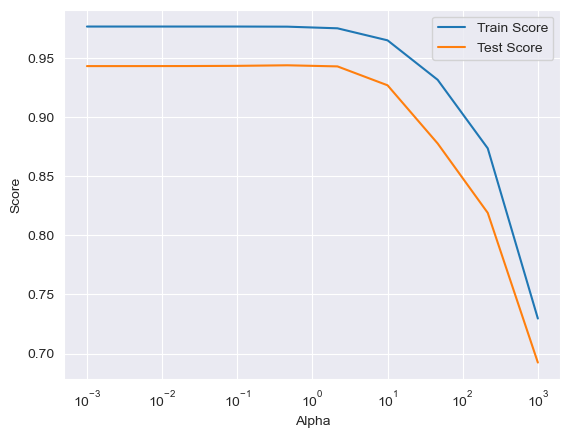

Najlepsza wartość alpha: 0.46415888336127775


In [134]:
#Sprawdzenie dla innych wartości parametru alpha
#Standaryzacja cech
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
    Ridge(), X_train_scaled, y_train, param_name="alpha", param_range=param_range, cv=5
)

plt.plot(param_range, train_scores.mean(axis=1), label="Train Score")
plt.plot(param_range, test_scores.mean(axis=1), label="Test Score")
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.show()

best_alpha_index = np.argmax(test_scores.mean(axis=1))  # Indeks najlepszego alpha na podstawie wyników testowych
best_alpha = param_range[best_alpha_index]
print(f'Najlepsza wartość alpha: {best_alpha}')

In [135]:
#Model Ridge Regression
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train_scaled, y_train)

# Prognozy na zbiorze testowym
y_pred_scaled = model_ridge.predict(X_test_scaled)
y_pred_train = model_ridge.predict(X_train_scaled)

# Obliczenie metryk
mae = mean_absolute_error(y_test, y_pred_scaled)
mse_test = mean_squared_error(y_test, y_pred_scaled)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_test, y_pred_scaled)

# Wyświetlenie wyników
print("Wyniki ewaluacji modelu regresji Ridge ze wszystkimi cechami:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Błąd treningowy: {rmse_train}")
print(f"Błąd testowy: {rmse_test}")
print(f"R² Score: {r2}")

nrmse_train = rmse_train / np.mean(y_train)
nrmse_test = rmse_test / np.mean(y_test)

print(f"Znormalizowany błąd uczący (NRMSE): {nrmse_train}")
print(f"Znormalizowany błąd testowy (NRMSE): {nrmse_test}")

# Wagi cech w modelu
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_ridge.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

Wyniki ewaluacji modelu regresji Ridge ze wszystkimi cechami:
Mean Absolute Error (MAE): 71014.67903665346
Błąd treningowy: 86808.31721230617
Błąd testowy: 98754.88140419546
R² Score: 0.9830228099572322
Znormalizowany błąd uczący (NRMSE): 0.28766979868293047
Znormalizowany błąd testowy (NRMSE): 0.2197950311258255
        Feature    Coefficient
14     n_pa_air  249948.033430
9         ex_in  233453.761540
4       n_co_tr  210635.959420
13        le_mo  195873.469265
1      le_ra_tr  157732.938019
6       n_ra_di   51128.296797
0         tr_tr   22744.458479
5       n_lo_di    9104.828667
12     co_pr_le  -14709.269138
3   le_li_up_hi  -21934.387238
10        in_in  -43456.344286
7       n_lo_el  -43742.718934
8         ca_ve -115450.486156
11           po -131242.533987
2      le_li_hi -231099.619943


### 2. Wizualizacja i ocena wyników oraz porównanie przed i po regularyzacji

## 5. Wnioski